In [ ]:
# Продолжайте развивать генератор данных.
# Решите задачу трекинга объектов.
# Этап 1. Генератор последовательности кадров с потоком клеток, перемещающихся "слева - направо".
#  - сгенерировать последовательность кадров в 10 секунд (итого - примерно 240 кдаров)
# - первичное положение клеток - случайный пиксель
# - при достижении границы изображения объект прекращает свое существование
# - пусть генератор пути клеток позволяет перемещать клетку по синусоиде  y(x(t) ) = ax+b + c * sin( omega *x) + eps_noise
# - a,b,c omega - случайно сгенерированные значения для данной клетки  eps_noise - случайное значение для каждой секунды
# - a,b,c omega - случайно сгенерированные значения для данной клетки
# - 10 секунду - 10 отсчетов времени t,  положение между кажром 0 и кадром 24 интерполируется при помощи линейной интерполяции по формуле:
# - выполнить то же самое, только зависимость не T(z),как в примере, а y(x)

In [ ]:
# Этап 2. Трекинг объектов.
# Используя пример, приведенный в лекции про трекинг, решить задачу трекинга объектов
# Пути (положения) объктов на каждом кадре сохранить в файл.
# Визуализировать траектории объектов на изображении.

In [ ]:
#Создание видео из последовательности кадров

In [15]:
!unzip /content/patches.zip -d /content/

Archive:  /content/patches.zip
   creating: /content/patches/
   creating: /content/patches/background/
 extracting: /content/patches/background/fon1.png  
  inflating: /content/patches/background/fon10.png  
  inflating: /content/patches/background/fon11.png  
  inflating: /content/patches/background/fon12.png  
 extracting: /content/patches/background/fon13.png  
  inflating: /content/patches/background/fon14.png  
 extracting: /content/patches/background/fon15.png  
 extracting: /content/patches/background/fon16.png  
 extracting: /content/patches/background/fon17.png  
  inflating: /content/patches/background/fon18.png  
  inflating: /content/patches/background/fon19.png  
 extracting: /content/patches/background/fon2.png  
  inflating: /content/patches/background/fon20.png  
  inflating: /content/patches/background/fon21.png  
 extracting: /content/patches/background/fon3.png  
 extracting: /content/patches/background/fon4.png  
 extracting: /content/patches/background/fon5.png  


Загружено: 21 фонов, 16 клеток


Генерация кадров:   0%|          | 0/240 [00:00<?, ?it/s]

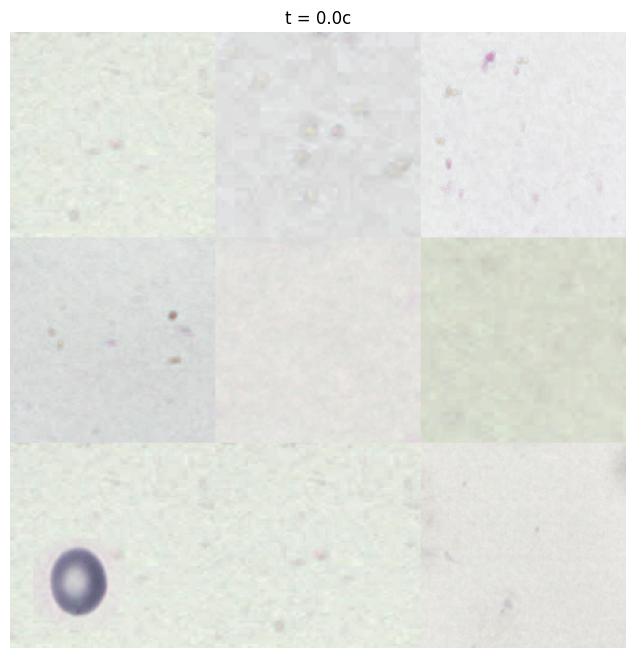

Генерация кадров:  25%|██▍       | 59/240 [00:00<00:01, 158.63it/s]

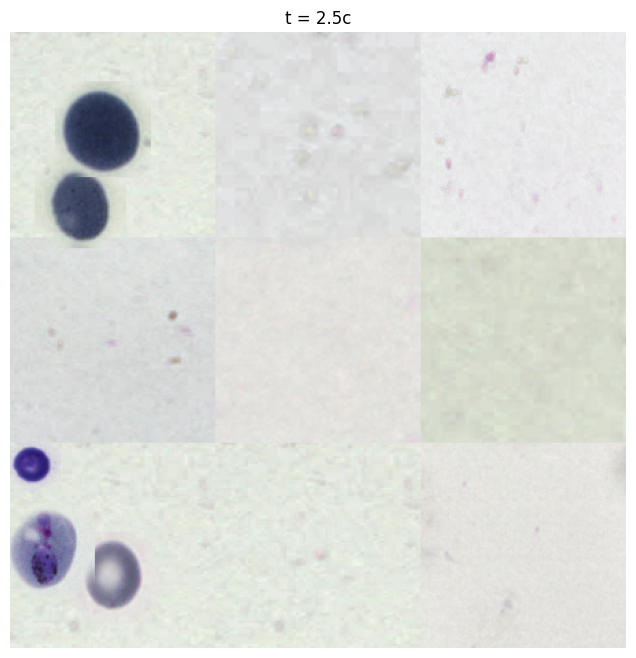

Генерация кадров:  45%|████▌     | 109/240 [00:01<00:01, 126.70it/s]

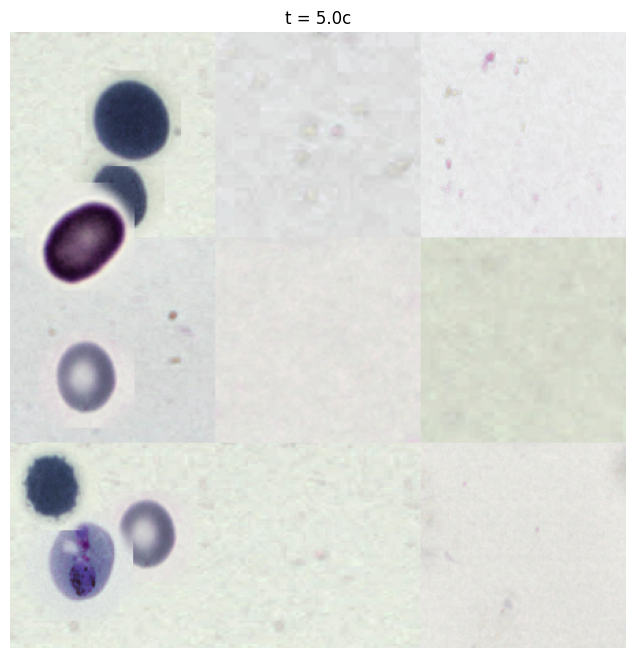

Генерация кадров:  92%|█████████▏| 221/240 [00:01<00:00, 168.76it/s]

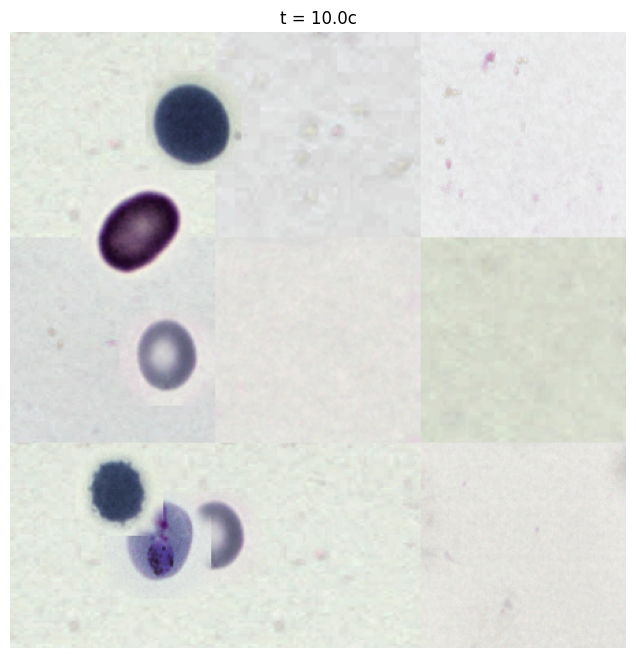

Генерация кадров: 100%|██████████| 240/240 [00:02<00:00, 108.04it/s]


Видео сохранено: cells.mp4


Tracking cells: 100%|██████████| 240/240 [00:03<00:00, 79.74it/s]


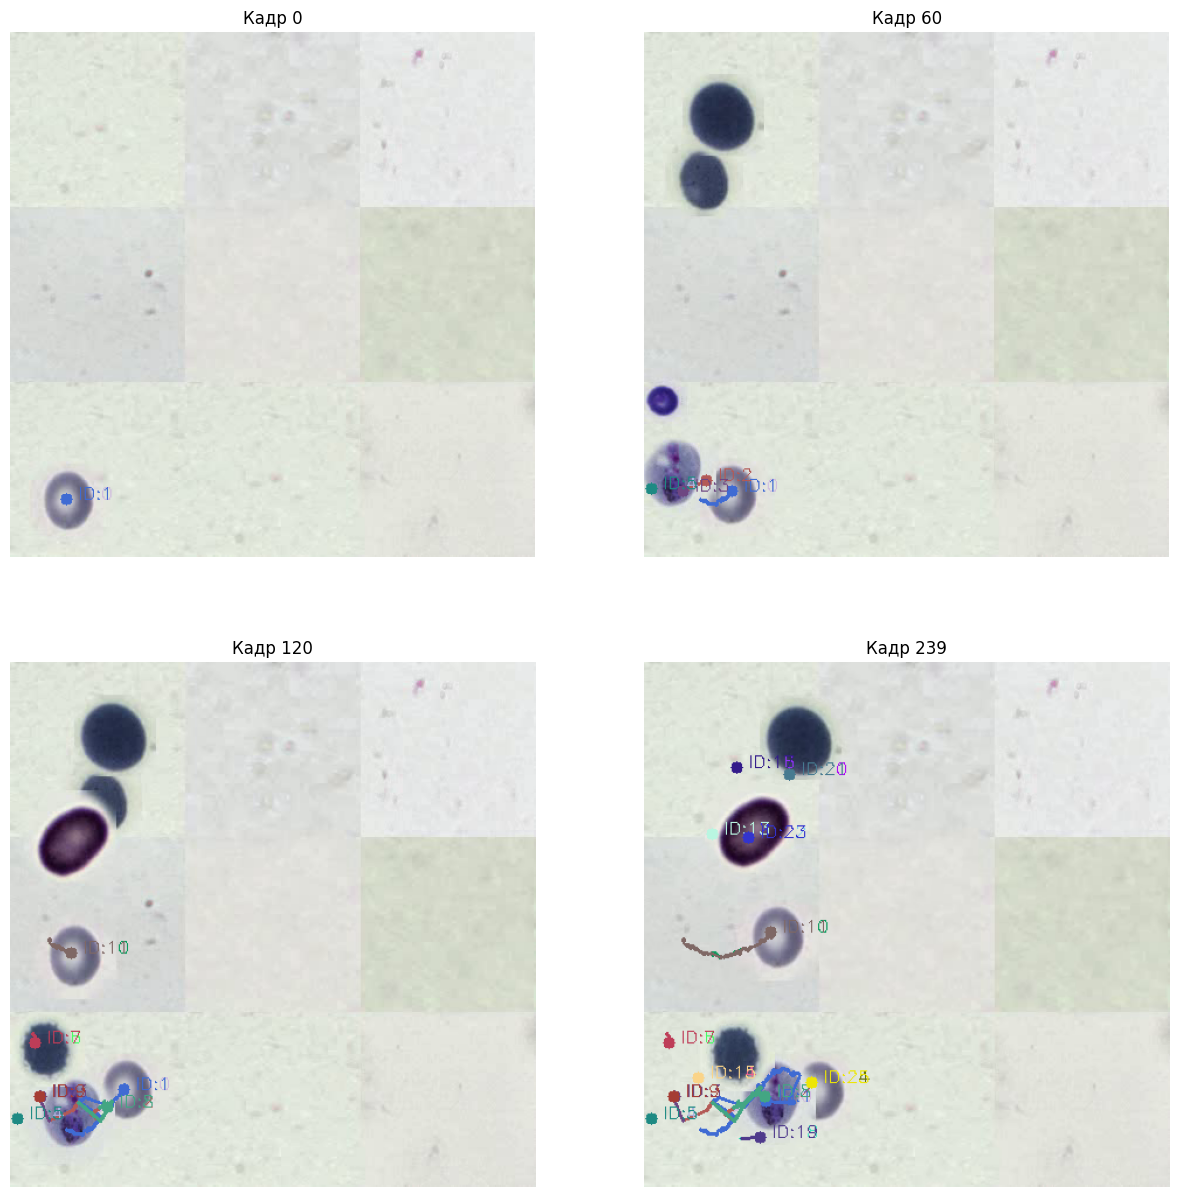

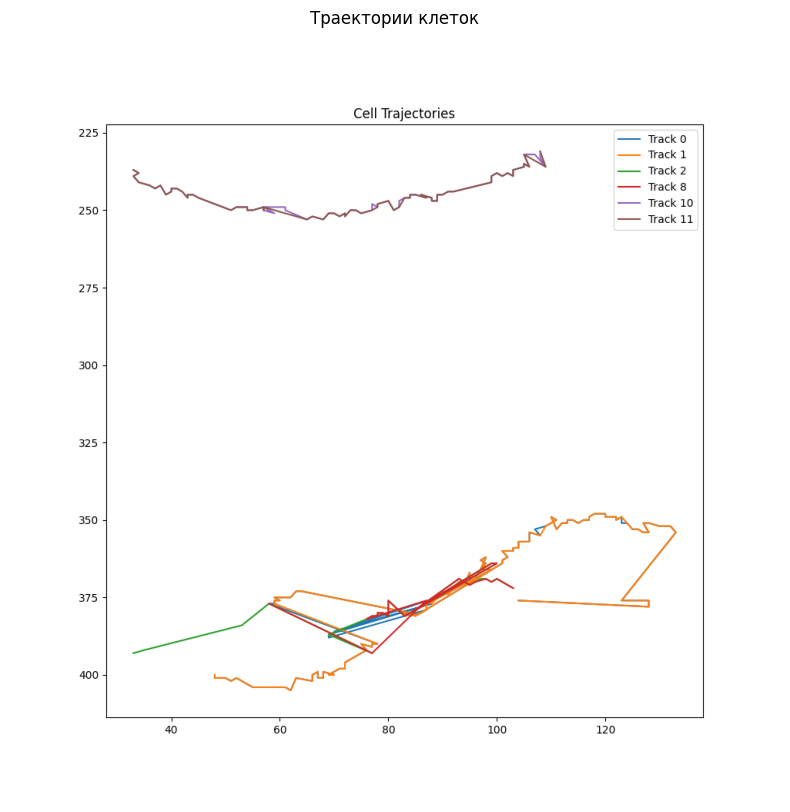

Трекинг завершен. Результаты сохранены в папке output/


In [16]:
import os
import random
import cv2
import numpy as np
import math
from tqdm import tqdm
from matplotlib import pyplot as plt



# Загрузка изображений (замените на ваш способ загрузки)
# Здесь предполагается, что у вас уже есть изображения в папках
# Если нужно загрузить из Google Drive, раскомментируйте следующее:


def load_images(folder):
    images = []
    for f in os.listdir(folder):
        if f.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = cv2.imread(os.path.join(folder, f))
            if img is not None:
                images.append(img)
    return images

def generate_3x3_background(bg_images, size=(450, 450)):
    bg = np.zeros((size[0], size[1], 3), dtype=np.uint8)
    patch_size = size[0] // 3

    for i in range(0, size[0], patch_size):
        for j in range(0, size[1], patch_size):
            if bg_images:
                patch = random.choice(bg_images)
                patch = cv2.resize(patch, (patch_size, patch_size))
                bg[i:i+patch_size, j:j+patch_size] = patch
    return bg

def draw_cell_with_blur(bg, cell_img, x, y, blur_size=21):
    h, w = bg.shape[:2]
    cell_h, cell_w = cell_img.shape[:2]

    if x >= w or y >= h or x + cell_w <= 0 or y + cell_h <= 0:
        return bg

    bg_x1, bg_x2 = max(0, x), min(w, x + cell_w)
    bg_y1, bg_y2 = max(0, y), min(h, y + cell_h)
    cell_x1, cell_x2 = max(0, -x), cell_w - max(0, x + cell_w - w)
    cell_y1, cell_y2 = max(0, -y), cell_h - max(0, y + cell_h - h)

    mask = np.zeros((cell_y2-cell_y1, cell_x2-cell_x1), dtype=np.float32)
    cv2.circle(mask,
              ((cell_x2-cell_x1)//2, (cell_y2-cell_y1)//2),
              min((cell_x2-cell_x1)//2, (cell_y2-cell_y1)//2),
              1, -1)
    mask = cv2.GaussianBlur(mask, (blur_size, blur_size), 0)
    mask = mask[..., None]

    bg[bg_y1:bg_y2, bg_x1:bg_x2] = (
        bg[bg_y1:bg_y2, bg_x1:bg_x2] * (1 - mask) +
        cell_img[cell_y1:cell_y2, cell_x1:cell_x2] * mask
    ).astype(np.uint8)

    return bg

class CellWithYofX:
    def __init__(self, img_size, cell_size):
        self.img_w, self.img_h = img_size
        self.size = cell_size

        self.x = random.randint(-cell_size//2, 20)
        self.y = random.randint(0, img_size[1] - cell_size)

        self.a = random.uniform(-0.3, 0.3)
        self.b = self.y
        self.c = random.uniform(10, 30)
        self.omega = random.uniform(0.03, 0.08)
        self.speed = random.uniform(8, 12)

        self.noise_phase = random.uniform(0, math.pi*2)
        self.noise_freq = random.uniform(0.5, 2.0)
        self.noise_amp = random.uniform(1, 3)

    def update(self, dt):
        self.x += self.speed * dt

        noise = math.sin(self.noise_phase) * self.noise_amp
        self.noise_phase += self.noise_freq * dt

        self.y = (
            self.b +
            self.a * self.x +
            self.c * math.sin(self.omega * self.x) +
            noise
        )

        self.y = max(0, min(self.img_h - self.size, self.y))

        return self.x < self.img_w + self.size

def generate_y_of_x_video(output_path, duration=10, fps=30, img_size=(450, 450), max_cells=7):
    bg_images = load_images("/content/patches/background")
    cell_images = load_images("/content/patches/cells")

    if not bg_images or not cell_images:
        raise ValueError("Проверьте папки с изображениями!")

    print(f"Загружено: {len(bg_images)} фонов, {len(cell_images)} клеток")

    background = generate_3x3_background(bg_images, img_size)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, img_size)

    cells = []
    total_frames = duration * fps

    for frame_idx in tqdm(range(total_frames), desc="Генерация кадров"):
        frame = background.copy()
        current_time = frame_idx / fps

        if len(cells) < max_cells and (frame_idx % 20 == 0 or len(cells) < 2):
            cell_img = random.choice(cell_images)
            cell_size = random.randint(40, 80)
            cell_img = cv2.resize(cell_img, (cell_size, cell_size))

            cells.append({
                'obj': CellWithYofX(img_size, cell_size),
                'img': cell_img
            })

        for cell in cells[:]:
            if not cell['obj'].update(1/fps):
                cells.remove(cell)
                continue

            x, y = int(cell['obj'].x), int(cell['obj'].y)
            frame = draw_cell_with_blur(frame, cell['img'], x, y)

        out.write(frame)

        if frame_idx in [0, total_frames//4, total_frames//2, total_frames-1]:
            plt.figure(figsize=(8, 8))
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.title(f"t = {current_time:.1f}с")
            plt.axis('off')
            plt.show()

    out.release()
    print(f"Видео сохранено: {output_path}")

# Генерация видео
try:
    generate_y_of_x_video(
        "cells.mp4",
        duration=10,
        fps=24,  # 10 секунд * 24 кадра = 240 кадров
        img_size=(450, 450),
        max_cells=8
    )
except Exception as e:
    print(f"Ошибка генерации видео: {e}")

# Класс для трекинга
class SimpleTracker:
    def __init__(self):
        self.tracks = {}
        self.next_id = 0

    def update(self, detections):
        if not self.tracks:
            for det in detections:
                self.tracks[self.next_id] = {
                    'positions': [self._center(det)],
                    'missed': 0
                }
                self.next_id += 1
            return self.tracks

        matched_det = set()
        updated_tracks = {}

        for track_id, track in self.tracks.items():
            last_pos = track['positions'][-1]
            min_dist = float('inf')
            best_match = None

            for i, det in enumerate(detections):
                if i in matched_det:
                    continue

                dist = self._distance(last_pos, self._center(det))
                if dist < 25:  # MAX_DISTANCE
                    if dist < min_dist:
                        min_dist = dist
                        best_match = i

            if best_match is not None:
                matched_det.add(best_match)
                track['positions'].append(self._center(detections[best_match]))
                track['missed'] = 0
                updated_tracks[track_id] = track

        for i, det in enumerate(detections):
            if i not in matched_det:
                self.tracks[self.next_id] = {
                    'positions': [self._center(det)],
                    'missed': 0
                }
                self.next_id += 1

        return self.tracks

    def _center(self, bbox):
        x, y, w, h = bbox
        return (x + w // 2, y + h // 2)

    def _distance(self, p1, p2):
        return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5

class BloodCellTracker:
    def __init__(self, video_path):
        self.cap = cv2.VideoCapture(video_path)
        if not self.cap.isOpened():
            raise ValueError(f"Не удалось открыть видео: {video_path}")

        self.MIN_CELL_AREA = 100
        self.MAX_CELL_AREA = 3000
        self.THRESHOLD = 15
        self.MIN_DISTANCE = 50
        self.MIN_ASPECT_RATIO = 1.0
        self.MAX_ASPECT_RATIO = 2.5

        self.kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
        self.trackers = []
        self.bboxes = []
        self.track_ids = []
        self.track_history = {}
        self.next_id = 0
        self.colors = np.random.randint(0, 255, (1000, 3))
        self.tracker = SimpleTracker()

    def preprocess_frame(self, frame):
        try:
            hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
            gray = hsv[:, :, 1]

            blurred = cv2.GaussianBlur(gray, (9, 9), 0)
            thresh = cv2.adaptiveThreshold(
                blurred, 255,
                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                cv2.THRESH_BINARY_INV, 11, 2
            )

            morphed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, self.kernel)
            morphed = cv2.morphologyEx(morphed, cv2.MORPH_OPEN, self.kernel)

            return morphed
        except Exception as e:
            print(f"Ошибка обработки кадра: {e}")
            return None

    def detect_cells(self, frame):
        mask = self.preprocess_frame(frame)
        if mask is None:
            return []

        contours, _ = cv2.findContours(
            mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        valid_boxes = []
        for cnt in contours:
            area = cv2.contourArea(cnt)
            perimeter = cv2.arcLength(cnt, True)
            circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter > 0 else 0
            if (self.MIN_CELL_AREA < area < self.MAX_CELL_AREA and
                    0.7 < circularity < 1.3):
                x, y, w, h = cv2.boundingRect(cnt)
                valid_boxes.append((x, y, w, h))
                aspect_ratio = max(w, h) / min(w, h)
                if self.MIN_ASPECT_RATIO < aspect_ratio < self.MAX_ASPECT_RATIO:
                    valid_boxes.append((x, y, w, h))

        return valid_boxes

    def update_tracking(self, frame):
        detections = self.detect_cells(frame)
        tracks = self.tracker.update(detections)

        self.track_history = {
            track_id: data['positions']
            for track_id, data in tracks.items()
            if data['missed'] < 5
        }

        return len(self.track_history)

    def visualize(self, frame):
        display_frame = frame.copy()

        for track_id, positions in self.track_history.items():
            color = self.colors[track_id % len(self.colors)].tolist()

            for i in range(1, len(positions)):
                cv2.line(display_frame, positions[i - 1], positions[i], color, 2)

            if positions:
                x, y = positions[-1]
                cv2.circle(display_frame, (x, y), 5, color, -1)
                cv2.putText(display_frame, f"ID:{track_id}", (x + 10, y),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        return display_frame

    def save_results(self, output_dir='output'):
        min_track_length = 10
        for track_id, positions in list(self.track_history.items()):
            if len(positions) < min_track_length:
                del self.track_history[track_id]
        os.makedirs(output_dir, exist_ok=True)

        with open(os.path.join(output_dir, 'tracks.csv'), 'w') as f:
            f.write("track_id,frame,x,y\n")
            for track_id, positions in self.track_history.items():
                for frame_num, (x, y) in enumerate(positions):
                    f.write(f"{track_id},{frame_num},{x},{y}\n")

        plt.figure(figsize=(10, 10))
        for track_id, positions in self.track_history.items():
            if len(positions) > 1:
                xs, ys = zip(*positions)
                plt.plot(xs, ys, label=f'Track {track_id}')

        plt.gca().invert_yaxis()
        plt.legend()
        plt.title("Cell Trajectories")
        plt.savefig(os.path.join(output_dir, 'trajectories.png'))
        plt.close()

    def run(self):
        total_frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        output_frames = []

        with tqdm(total=total_frames, desc="Tracking cells") as pbar:
            while True:
                ret, frame = self.cap.read()
                if not ret:
                    break

                try:
                    detections = self.detect_cells(frame)
                    active_count = self.update_tracking(frame)
                    tracked_frame = self.visualize(frame)
                    output_frames.append(tracked_frame)

                    if cv2.waitKey(1) == 27:  # ESC для выхода
                        break

                    pbar.update(1)
                except Exception as e:
                    print(f"Ошибка обработки кадра: {e}")
                    break

        # Сохраняем видео с трекингом
        height, width = output_frames[0].shape[:2]
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter('tracked_cells.mp4', fourcc, 24, (width, height))

        for frame in output_frames:
            out.write(frame)
        out.release()

        self.save_results()
        self.cap.release()
        cv2.destroyAllWindows()

        # Показываем результаты
        plt.figure(figsize=(15, 15))

        # Показываем несколько кадров с трекингом
        for i, idx in enumerate([0, len(output_frames)//4, len(output_frames)//2, len(output_frames)-1]):
            plt.subplot(2, 2, i+1)
            plt.imshow(cv2.cvtColor(output_frames[idx], cv2.COLOR_BGR2RGB))
            plt.title(f"Кадр {idx}")
            plt.axis('off')

        plt.show()

        # Показываем траектории
        self.save_results()
        img = cv2.imread('output/trajectories.png')
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Траектории клеток")
        plt.show()

# Запускаем трекинг
video_path = 'cells.mp4'
tracker = BloodCellTracker(video_path)
tracker.run()
print("Трекинг завершен. Результаты сохранены в папке output/")